# pyRootHair Demonstration ipynb 

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import imageio.v3 as iio

from skimage.measure import label, regionprops
from skimage.morphology import skeletonize
from skimage.transform import rotate, warp, PiecewiseAffineTransform
from scipy.ndimage import convolve
from scipy.spatial.distance import euclidean
from scipy.interpolate import CubicSpline
from statsmodels.nonparametric.smoothers_lowess import lowess


In [7]:
image = iio.imread('~/Images/Wheat/CSC_Images/Raw/karim_demo.png')
mask = iio.imread('~/Images/Wheat/CSC_Images/Masks/karim_demo_mask.png')

Text(0.5, 1.0, 'Binary Mask')

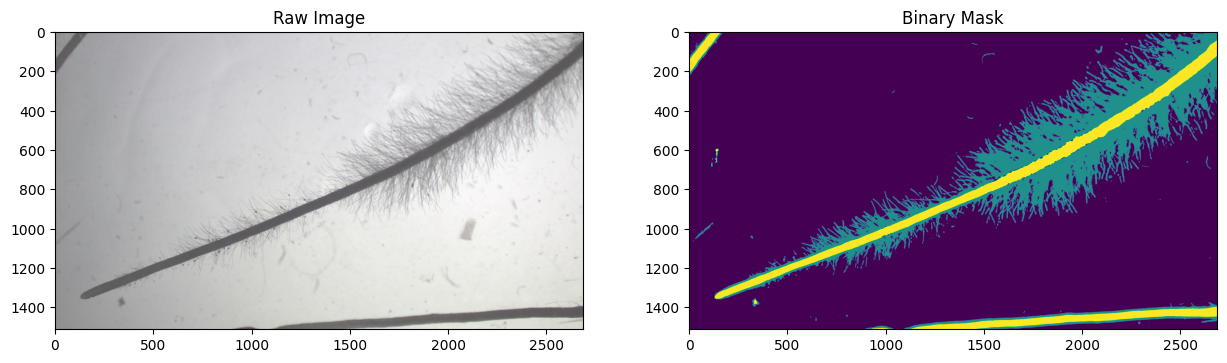

In [13]:
fig, ax = plt.subplots(ncols=2, figsize=(15,10))
ax[0].imshow(image)
ax[0].set_title('Raw Image')
ax[1].imshow(mask)
ax[1].set_title('Binary Mask')